Note: the notebook is not fully ready yet


# Installation
The purpose of this notebook is to give a working example of the library and how to use it. First, we begin by installing the library

In [1]:
%pip install --upgrade --force-reinstall git+https://github.com/JadM133/RRAEs.git

  Cloning https://github.com/JadM133/RRAEs.git to c:\users\jadmo\appdata\local\temp\pip-req-build-5ck2f876
  Resolved https://github.com/JadM133/RRAEs.git to commit 8cd9bb0f8f5268f0bcd2591eca7a3b7df471a500
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached equinox-0.13.2-py3-none-any.whl.metadata (19 kB)
  Using cached jax-0.7.2-py3-none-any.whl.metadata (13 kB)
  Using cached jaxlib-0.7.2-cp313-cp313-win_amd64.whl.metadata (1.4 kB)
  Using cached jaxtyping-0.3.3-py3-none-any.whl.metadata (7.8 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached numpy-2.3.3-cp313-cp313-win_amd64.whl.metadata (60 k

  Running command git clone --filter=blob:none --quiet https://github.com/JadM133/RRAEs.git 'C:\Users\jadmo\AppData\Local\Temp\pip-req-build-5ck2f876'
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'c:\\users\\jadmo\\desktop\\test\\.venv\\scripts\\pytest.exe'
Check the permissions.



In [1]:
# Always start by importing the configuration file to run some necessary setup things
import RRAEs.config

## Data generation
You can acces the library with the name ``RRAEs``. We begin by creating a simple training data, the library presents a function within ``utilities`` named ``get_data`` that generates the data used in the paper and many more. In this case, we will use the shifted sine functions as a simple example.

Train shape: (200, 199), or (200, 199)
Test shape: (200, 498), or (200, 498)
Train parameters shape: (199, 1)
Test parameters shape: (498, 1)


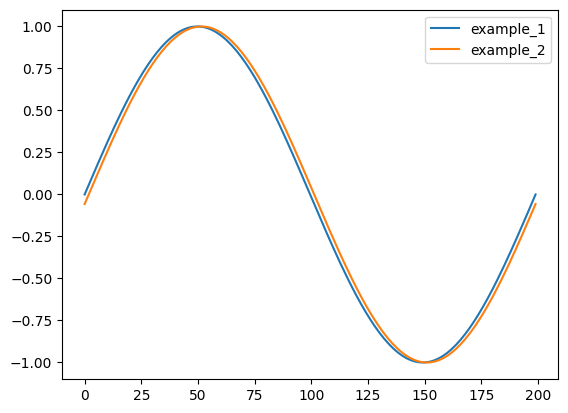

In [2]:
from RRAEs.utilities import get_data
import matplotlib.pyplot as plt
import jax.numpy as jnp
x_train, x_test, p_train, p_test, y_train, y_test, _, _, _ = get_data("shift")
# In general, you won't use get_data, you will have your own data with the same shapes.
# For more instructions on how to create your own data, refer to the Readme file
print(f"Train shape: {x_train.shape}, or {y_train.shape}")
print(f"Test shape: {x_test.shape}, or {y_test.shape}")
print(f"Train parameters shape: {p_train.shape}")
print(f"Test parameters shape: {p_test.shape}")
plt.plot(x_train[:, 0], label="example_1")
plt.plot(x_train[:, 2], label="example_2")
plt.legend()

In this case, ``x_train`` and ``y_train`` are the same matrices, since we want the autoencoder to have as an output the same thing as the input. Similarly, ``x_test`` and ``y_test`` are the same. We can also see that we only have one parameter (the last dimension of ``p_train`` and ``p_test``), which is expected for the problem of the shifted sines (shifted by one parameter). In general, when generating your own data, x and y should have the shape (T x N) and the parameters should have a shape of (N x P), N being the number of samples (wether for train or test), T being the time discretisation dimension, and P being the dimension of the parametric space.

## Training

The training class provides simple functions for fitting and evaluating Networks. It is also an easy
way of applying normalization, and vectorizing the inputs for both the encoder and the decoder.

In this case, we will use a subclass, ``RRAE_Trainor_class``, specifically designed for Rank Reduction Autoencoders.

We define the trainor class as follows, 

In [12]:
from RRAEs.training_classes import RRAE_Trainor_class 
from RRAEs.AE_classes import RRAE_MLP
import jax.random as jrandom

# You can use Trainor_class instead for any other equinox model,
# (check general-MLP.py for an example)
 
# RRAE_trainor_class is specifically designed for RRAEs.
# It finds the common basis over the batches and allows for
# fine tuning if needed.

k_max = 1 # the bottleneck size (level of truncation of the SVD)
latent_size = 200 # the size of the latent space (bigger than bottleneck k)

model_cls = RRAE_MLP # Without parenthesis! Only the class

trainor = RRAE_Trainor_class(
            x_train,
            model_cls,
            in_size=x_train.shape[0],
            latent_size=latent_size,
            k_max=k_max,
            norm_in="None", # could choose "meanstd", or "minmax"
            norm_out="None", # could choose "meanstd", or "minmax"
            kwargs_enc={
            "width_size": 300,
            "depth": 1,
            },
            kwargs_dec={
                "width_size": 300,
                "depth": 6,
            },
            out_train=x_train, # to extract data for norm at output
            folder=f"test/", # folder to save later
            file=f"testing_RRAE.pkl", # file in folder to save later
            key=jrandom.PRNGKey(0),
        )

Now, we can use the ``fit`` method of the trainor class, to fit the model on some data.

Note that as discussed in the paper, RRAEs might benefit of some fine tuning of the final basis found.
Accordingly, the AE trainor class used performs two types of training. First, RRAEs are trained with
an SVD in the latent space. Then, the fine tuning is done with a fixed basis and a projection in the
latent space.

In [13]:
# Here define training arguments for the RRAEs with an SVD.
training_kwargs = {
            "step_st": [1500], # number of batches (forward/backward passes) strategy
            "batch_size_st": [64], # batch size strategy
            "lr_st": [1e-3], # learning rate strategy
            "print_every": 1,
            "save_losses": True # set to True if you want to save the loss over training
        }

# Here define the parameters of fine-tuning.
ft_kwargs = {
            "step_st": [0], # change to > 0 if you want to fine tune
            "batch_size_st": [5], # batch size strategy
            "lr_st": [1e-4], # learning rate strategy
            "print_every": 100,
        }

_ = trainor.fit(
    x_train,
    y_train,
    training_key=jrandom.PRNGKey(50),
    training_kwargs=training_kwargs,
    ft_kwargs=ft_kwargs,
)

Training RRAEs...
Batch: 0, loss: 100.14834594726562, val_loss: None, Time [s]: 0.41656459984369576, Total time [s]: 0.41656459984369576
Batch: 1, loss: 99.95718383789062, val_loss: None, Time [s]: 0.0096539999358356, Total time [s]: 0.42621859977953136
Batch: 2, loss: 100.00648498535156, val_loss: None, Time [s]: 0.0074356000404804945, Total time [s]: 0.43365419982001185
Batch: 3, loss: 99.66226959228516, val_loss: None, Time [s]: 0.008992599789053202, Total time [s]: 0.44264679960906506
Batch: 4, loss: 98.85620880126953, val_loss: None, Time [s]: 0.00737560004927218, Total time [s]: 0.45002239965833724
Batch: 5, loss: 96.94190979003906, val_loss: None, Time [s]: 0.006209899904206395, Total time [s]: 0.45623229956254363
Batch: 6, loss: 95.48738861083984, val_loss: None, Time [s]: 0.006089800037443638, Total time [s]: 0.46232209959998727
Batch: 7, loss: 85.9983901977539, val_loss: None, Time [s]: 0.00627589994110167, Total time [s]: 0.46859799954108894
Batch: 8, loss: 84.9767837524414,

4it [00:00,  9.62it/s]                       

Defaulting to standard loss
Fine tuning the basis ...


## Evaluation

Next, we show how to evaluate the network on train/test. Again, this can be simply done using the trainor class.

In [15]:
preds = trainor.evaluate(x_train, y_train, x_test, y_test)

Finding train predictions...


100%|██████████| 40/40 [00:01<00:00, 31.88it/s]


Train error on original output:  76.941956
Train error on normalized output:  76.941956
Test error on original output:  77.16201
Test error on normalized output:  77.16201
Total training time:  0.0


In [7]:
# _o stands for original (no normalization) and its absence stands for normalized.
preds.keys()

dict_keys(['error_train', 'error_test', 'error_train_o', 'error_test_o', 'y_pred_train_o', 'y_pred_test_o', 'y_pred_train', 'y_pred_test'])

Let's plot one our predictions on one of the test curves.

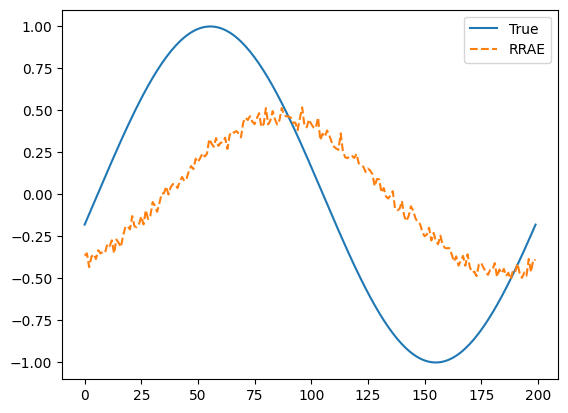

In [10]:
idx = 15
plt.plot(y_test[:, idx], label="True")
plt.plot(preds["y_pred_test_o"][:, idx], label="RRAE", linestyle="--")
plt.legend()

In [10]:
import os
import dill
idx = 0
with open(os.path.join("test", f"all_losses_{2}.pkl"), "rb") as f:
    res_list = dill.load(f)
res_list[0]

{'loss': Array(100.93706, dtype=float32), 'val_loss': None}

You can plot the losses as follows

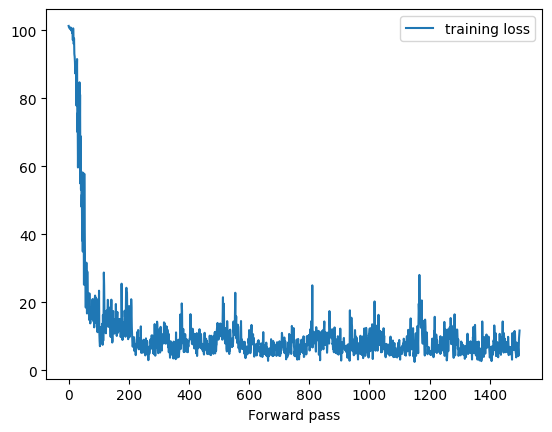

In [11]:
# if you use this in a script, you have to do plt.show() after
trainor.plot_training_losses()

## Post processing and other operations

The autoencoder model also allows you to perform seperate operations (e.g. encode and decode), normalization is done automatically.

In [12]:
encoded = trainor.model.encode(x_train) # data is normalized before encode

# We con both encode, and project on the basis as follows (do not forget the apply_basis argument).
# Note that when using trainor.evaluate, this is done automatically.
latent = trainor.model.latent(x_train, apply_basis=trainor.basis) # data is normalized before latent

# Then we can decode the results to find the prediction
decoded = trainor.model.decode(latent) # data is inv normalized after decode
print(jnp.linalg.norm(x_train - decoded)/jnp.linalg.norm(x_train)*100) #Finding the error in percentage

80.84259


Note that the function "latent", has some useful arguments as well:

In [13]:
# get_basis_coeffs=True returns the basis, and corresponding coefficients of the
# truncated SVD in the latent space (Note: if the svd is USV^T, then
# the basis is U, the coefficients are SV^T).
# The coeffs are the reduced representation of the data (shape k_max x D).
basis, coeffs = trainor.model.latent(x_train, k_max=1, get_basis_coeffs=True)
print(coeffs.shape)

# By default, the latent space performs the truncated SVD by the value of
# k_max specified above. This is needed when performing training. But to
# evaluate an RRAE, we should project on the basis already found during
# training. This can be done by setting apply_basis=basis wether in the
# latent, or in the __call__ function of the model.
latent_space = trainor.model.latent(x_train, apply_basis=basis)

(1, 17)


Some of the trainor attributes and methods that could be useful:

In [14]:
print(trainor.__dict__.keys()) #  a list of all the attributes of the trainor, you can find the errors, the model, the basis, etc.

# NOTE: In case your data is big and you want to perform any function using
# mapped batches, eval_with_batches from RRAEs.utilities can be used as follows.

from RRAEs.utilities import eval_with_batches
# Step 1: Specify the function you want to apply
call_func = lambda x: trainor.model.latent(x, k_max=1, get_basis_coeffs=True)[0]

# gets the mean of all bases
latent_space_mean = eval_with_batches(x_train, batch_size=5, call_func=call_func, end_type="mean", key_idx=0)

print(f"Mean basis shape: {latent_space_mean.shape}")

# NOTE: By default, the function assumes only ONE ARRAY as an output, so the results of each batch
# are appended in a list, and the concatenated along the last dimension. You could chose end_type
# to be "mean" where the function would return the mean of the list, "first" if you only want the result
# over the first batch, and None if you want the list of results. 

dict_keys(['k_init', 'adap_type', 'model', 'all_kwargs', 'folder', 'file', 'adapt', 'pre_func_inp', 'batch_size', 't_all', 'track_params', 'basis', 'ft_track_params', 'error_train_o', 'error_train', 'error_test_o', 'error_test'])
Mean basis shape: (200, 1)


Finally, you can save the model by using the built-in ``save_model`` function of the trainor class, it will save the model in the foler and file that you specified previously when defining the trainor class as follows.

In [15]:
trainor.save_model(coeffs=coeffs, basis=basis) # you could save any other parameter by passing it as a keyword argument

Model saved in test/testing_RRAE.pkl


Later on, if you want to load the trainor again, you define a trainor class instance with no attributes and load the class as follows

In [16]:
import os
folder = f"test/"
file = f"testing_RRAE.pkl"
new_trainor = RRAE_Trainor_class()
new_trainor.load_model(os.path.join(folder, file), erase=True) # erase=True to delete the saved file, only to use in this tutorial.

new_trainor.model # Access the model, and all the other attributes of the trainor.

RRAE_MLP(
  _encode=MLP_with_linear(
    layers=(
      Linear(
        weight=f32[64,200],
        bias=f32[64],
        in_features=200,
        out_features=64,
        use_bias=True
      ),
      Linear(
        weight=f32[200,64],
        bias=f32[200],
        in_features=64,
        out_features=200,
        use_bias=True
      )
    ),
    activation=<PjitFunction of <function relu at 0x00000255041B2C00>>,
    final_activation=<function <lambda>>,
    use_bias=True,
    use_final_bias=True,
    in_size=200,
    out_size=200,
    width_size=64,
    depth=1,
    layers_l=()
  ),
  _decode=MLP_with_linear(
    layers=(
      Linear(
        weight=f32[64,200],
        bias=f32[64],
        in_features=200,
        out_features=64,
        use_bias=True
      ),
      Linear(
        weight=f32[64,64],
        bias=f32[64],
        in_features=64,
        out_features=64,
        use_bias=True
      ),
      Linear(
        weight=f32[64,64],
        bias=f32[64],
        in_featu